<a href="https://colab.research.google.com/github/NehaSontakk/RNA-sequencing-fastq-to-differential-gene-expression/blob/main/EdgeR_Normalization_190423.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge R normalization

Written by Neha Sontakke and aided by Akshara Dubey and Nitish Malhotra's Integrated Omics 3 course



Creating a directory to store your coverage files

In [ ]:
dir.create(file.path("/content/data/"), showWarnings = FALSE)

### Installing softwares

In [ ]:
#Packages needed for edgeR analysis
install.packages("BiocManager")
#Package for storing the output in excel
install.packages("openxlsx")
#Package to perform statistical operations
install.packages("statmod")
install.packages("psych")

library(openxlsx)
library(BiocManager)
BiocManager::install("edgeR")
library(edgeR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.20), R 4.3.0 (2023-04-21)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR'”
Old packages: 'bit', 'bslib', 'curl', 'devtools', 'digest', 'gert', 'highr',
  'isoband', 'jsonlite', 'pkgload', 'roxygen2', 'tidyverse', 'usethis',
  'whisker', 'boot', 'foreign'



**Loading the data**

In [ ]:
GenewiseCounts <- c()
Gene_coverage <- c()
X <- c()
index= 0
#read all files from the data directory
list_all = list.files("/content/data")
#for all files create a combined matrix/dataframe
for (filename in list_all) {
  print(filename)
  index = index +1
  A <- read.table(paste("/content/data",filename, sep="/"),header = F,sep="\t")
  #remove any rrna details to reduce skewing of normalization
  A <- A[!grepl("CCNA_R", A$V5),]
  #Gene column is specified as the 5th one
  Genes <- A$V5
  gene_name <- A$V5
  #The read count columns in .cov files are the 7th column
  GenewiseCounts <- cbind(GenewiseCounts,A$V7)
}

#specify the rownames in a seperate array
rownames(GenewiseCounts) <- Genes

[1] "lexASidAReplicate1_R1_R2_001.cov"
[1] "lexASidAReplicate2_R1_R2_001.cov"
[1] "WT_0_S1_R1_R2_001.cov"
[1] "WT_0hr_MMS_Replicate1.cov"
[1] "WT_0hr_MMS_Replicate2.cov"
[1] "WT2_0_S11_R1_R2_001.cov"


###  Specifying the names of the samples and number of files for that replicate, do this in the order of files given above.

In [ ]:
#The data below needs to be filled in as per your samples 
#For example: paste(rep("SAMPLENAME",NUMBER_OF_COVERAGE_FILES),seq(1,NUMBER_OF_COVERAGE_FILES),sep = "_")
#So for each sample this needs to be specified like the example given below for lexA sidA
colnames(GenewiseCounts) <- c(
paste(rep("lexASidA",2),seq(1,2),sep = "_"),
paste(rep("WT_0",4),seq(1,4),sep = "_"))

### Specify sample name and number of replicates in the order they are specified above.

In [ ]:
group<- c(rep("lexASidA",2),rep("WT_0",4))
print(group)

[1] "lexASidA" "lexASidA" "WT_0"     "WT_0"     "WT_0"     "WT_0"    


### The groups and library sizes for all samples and all replicates


edgeR stores data in a simple list-based data object called a DGEList. This type of object is easy to use because it can be manipulated like any list in R. The function readDGE makes a DGEList object directly. If the table of counts is already available as a matrix or a data.frame, x say, then a DGEList object can be made by the following code.

The main components of an DGEList object are a matrix counts containing the integer counts, a data.frame samples containing information about the samples or libraries, and a optional data.frame genes containing annotation for the genes or genomic features. The data.frame samples contains a column lib.size for the library size or sequencing depth for each sample. If not specified by the user, the library sizes will be computed from the column sums of the counts. For classic edgeR the data.frame samples must also contain a column group, identifying the group membership of each sample.

In [ ]:
y<-DGEList(GenewiseCounts,group=group)
y$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
lexASidA_1,lexASidA,16875772,1
lexASidA_2,lexASidA,17905516,1
WT_0_1,WT_0,9765936,1
WT_0_2,WT_0,2174980,1
WT_0_3,WT_0,1960900,1
WT_0_4,WT_0,12148347,1


## MD Plots

of a single sample specified by the variable below. 

A mean-difference plot (MD-plot) is a plot of log fold changes (differences) versus average log values (means). The history of mean-difference plots and MA-plots is reviewed in Ritchie et al (2015).

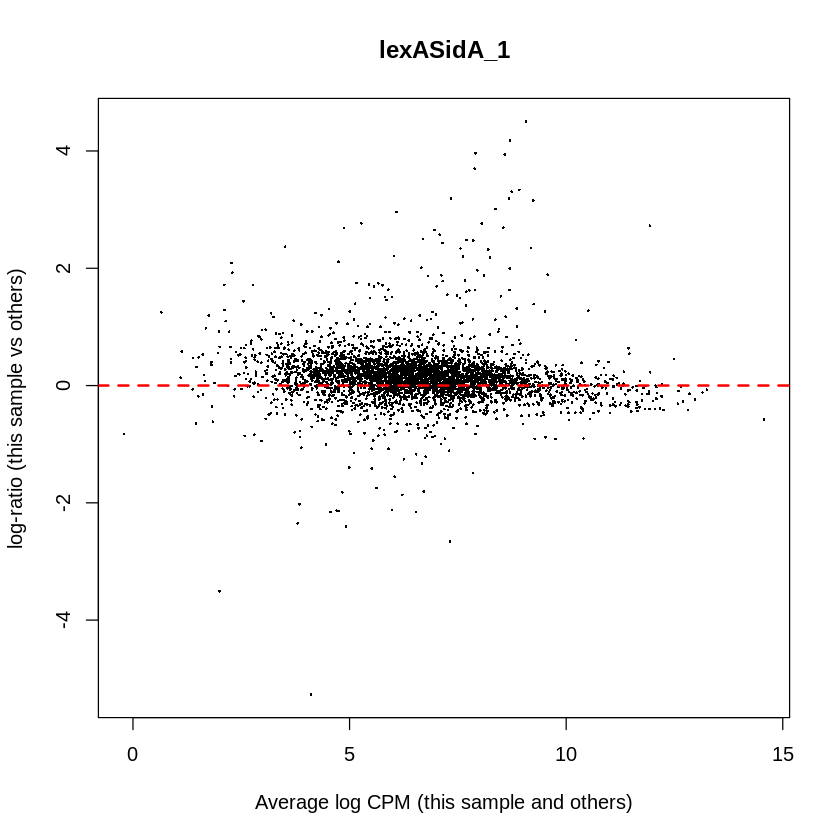

In [ ]:
#specify column to plot
plotMD(y,column=1)
abline(h=0,col="red",lty=2,lwd=2)

### Important step to calculate normalized data

RNA-seq provides a measure of the relative abundance of each gene in each RNA
sample, but does not provide any measure of the total RNA output on a per-cell basis. In other words, RNA-seq measure relative expression rather than absolute expression. This becomes important for differential expression analyses when a small number of genes are very highly expressed in some samples but not in others. If a small proportion of highly expressed genes consume a substantial proportion of the total library size for a particular sample, this will cause the remaining genes to be under-sampled for that sample. Unless this effect is
adjusted for, the remaining genes may falsely appear to be down-regulated in that sample.

The normLibSizes function normalizes the library sizes in such a way to minimize the log-fold changes between the samples for most genes. The default method for computing these scale factors uses a trimmed mean of M-values (TMM) between each pair of samples. We call the product of the original library size and the scaling factor the effective library size, i.e., the normalized library size. The effective library size replaces the original library size in all downsteam analyses. TMM is recommended for most RNA-Seq data where the majority (more than half) of the genes are believed not differentially expressed between any pair of the samples. If y is a DGEList object, then the following commands perform the TMM normalization and display the normalization factors.

In [ ]:
y<-calcNormFactors(y)

### Plotting the MDS (this is just log-normalised PCA)

We explore the pseudo-bulk profiles using a multi-dimensional scaling (MDS) plot. This visualizes the differences between the expression profiles of different samples in two dimensions. It can be seen that pseudo-bulk samples from the same cell cluster are close to each other.

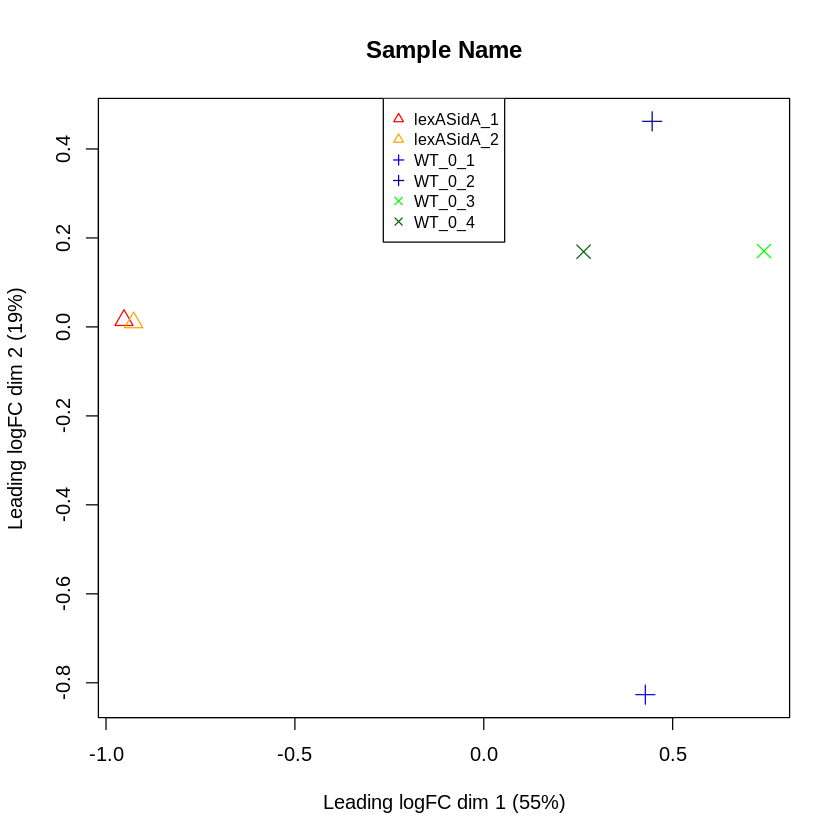

In [ ]:
#optional step to specify shapes and colors in the plot
pch<- c(rep(2,2),rep(3,2),rep(4,2),rep(5,2),rep(6,2),rep(7,2),rep(8,2),rep(9,2),rep(10,2))
colors<- c(rep("red",1),rep("orange",1),rep("blue",1),rep("dark blue",1),rep("green",1),rep("dark green",1))
plotMDS(y,col=colors,pch = pch,cex=1.5)
legend("top", legend=colnames(y), pch=pch, col=colors,ncol = 1,cex =0.8)
title("Sample Name")

### Making group matrix

In [ ]:
design <- model.matrix(~0+group)

### estimateDisp: 
Estimate Common, Trended and Tagwise Negative Binomial dispersions by weighted likelihood empirical Bayes

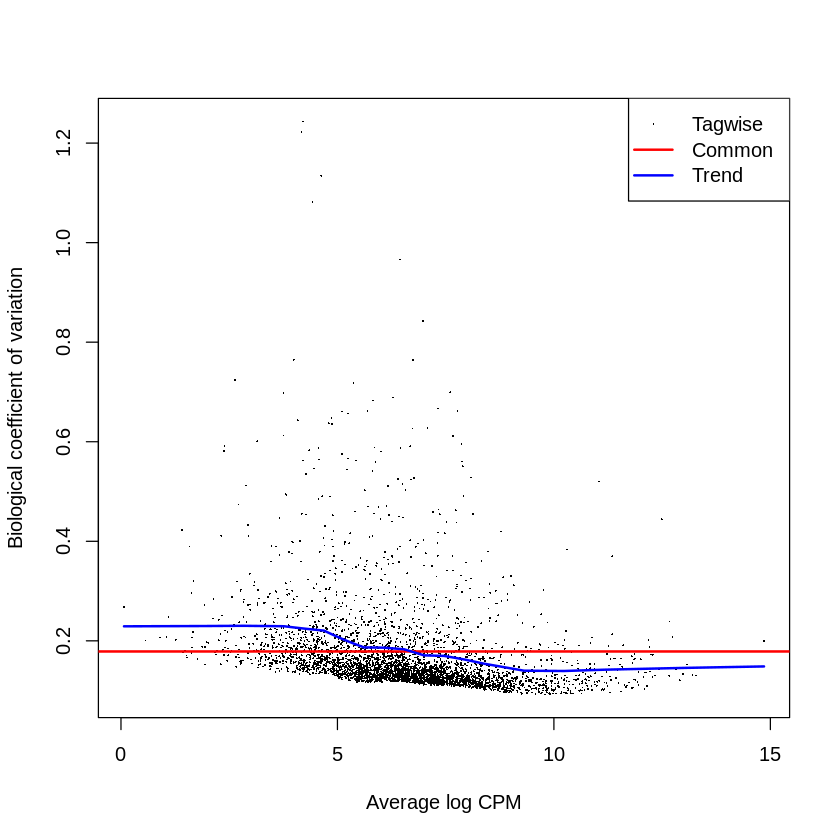

In [ ]:
y<-estimateDisp(y,design,robust=TRUE)
plotBCV(y)

### glmQLFit
Genewise Negative Binomial Generalized Linear Models with Quasi-likelihood Tests. Fit a quasi-likelihood negative binomial generalized log-linear model to count data. Conduct genewise statistical tests for a given coefficient or contrast. 

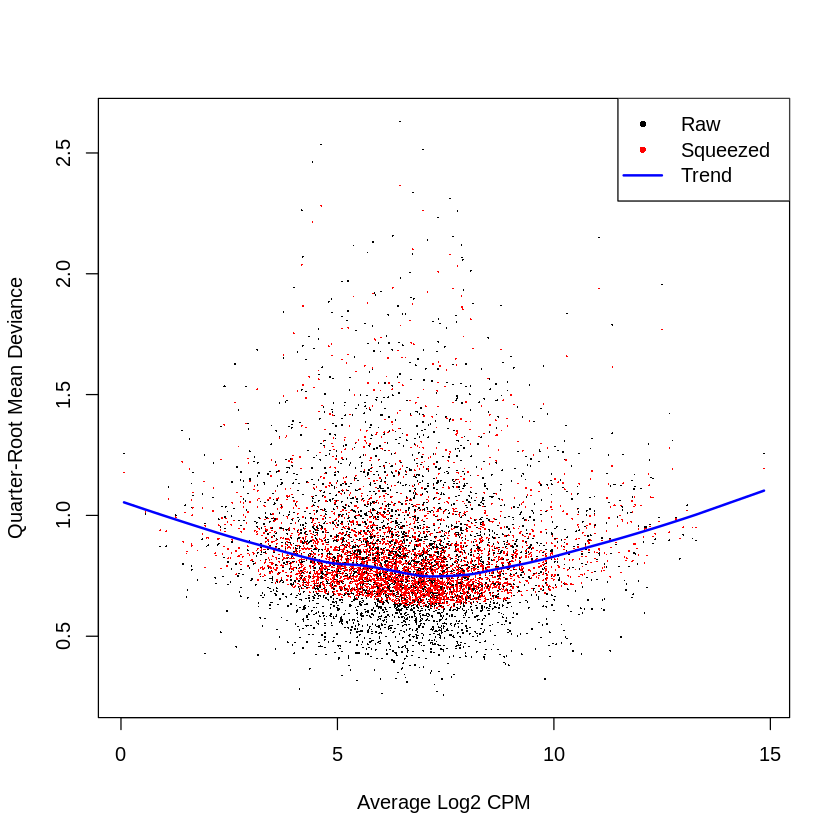

In [ ]:
fit<-glmQLFit(y,design,robust=TRUE)
plotQLDisp(fit)

### Count per million calculation

Computes counts per million (CPM) or reads per kilobase per million (RPKM) values.

In [ ]:
logCPM<-cpm(y,log=TRUE)
head(logCPM)
t_logCPM<-t(scale(t(logCPM)))

,lexASidA_1,lexASidA_2,WT_0_1,WT_0_2,WT_0_3,WT_0_4
CCNA_00001,6.928730,6.951522,6.953756,6.973908,6.835688,7.073736
CCNA_00002,6.377986,6.402856,6.297970,6.213589,6.302179,6.405131
CCNA_00003,6.758101,6.778215,6.359067,6.213589,6.085647,6.403732
CCNA_00004,6.290730,6.288838,5.897265,5.514349,6.134011,6.044686
CCNA_00005,7.172318,7.176206,7.379900,7.268763,7.417407,7.306486
CCNA_00006,7.714405,7.750938,7.456451,7.225096,7.352461,7.518536


### Ouput file for all the CPM normalised reads (THIS IS NOT THE END!)

In [ ]:
table_for_norm_reads <- as.data.frame(logCPM)

In [ ]:
write.xlsx(table_for_norm_reads,"logCPM_normalised_reads.xlsx")

## Comparative Group definition (requires user input)

In [ ]:
#You can add as many comma seperated groups as you want
comparisons<-c("grouplexASidA-groupWT_0")

### Number of comparisons to be made (as specified above)

In [ ]:
length(comparisons)

[1] 1

### Code below generates log fold change files for all comparisons specified above

In [ ]:
dir.create(file.path("/content/Log_fold_change_and_normalised_CPM_values/"), showWarnings = FALSE)

In [ ]:
for (i in 1:length(comparisons)) {
  x = comparisons[i] #for all groups specified above
  print(x)
  mvsw<-makeContrasts(x,levels=design)
  res<-glmQLFTest(fit,contrast=mvsw)
  W<- topTags(res,n = nrow(res$table))
  print(head(W))
  name_of_df <- paste("/content/Log_fold_change_and_normalised_CPM_values/",x,"_LFC_edgeR_normalised.xlsx")
  write.xlsx(W$table,name_of_df,colNames=TRUE, rowNames=TRUE)
}

[1] "grouplexASidA-groupWT_0"
Coefficient:  1*grouplexASidA -1*groupWT_0 
               logFC   logCPM         F       PValue          FDR
CCNA_01391  4.849185 9.013506 1843.0039 4.555991e-10 9.598211e-07
CCNA_03118  5.107967 9.221907 1802.5863 4.939892e-10 9.598211e-07
CCNA_01979 -6.904830 7.524942 1212.6499 2.095494e-09 2.714363e-06
CCNA_02418  3.159195 6.924239 1065.5418 3.355494e-09 2.980804e-06
CCNA_02973  3.047543 7.650913 1027.1143 3.835312e-09 2.980804e-06
CCNA_03317  3.962571 8.888638  942.9302 5.234651e-09 3.390309e-06


In [ ]:
#x = comparisons[1] #for first comparative group
#mvsw<-makeContrasts(x,levels=design)
#res<-glmQLFTest(fit,contrast=mvsw)
#W<- topTags(res,n = nrow(res$table))
#write.xlsx(W,"delrecA_20_LFC_edgeR_normalised_for_Figure1.xlsx")
#head(W)
#with(W$table, plot(logFC, -log10(PValue), pch=20, main="Volcano plot",col=ifelse((FDR <= 0.05 & abs(logFC) >= log2(2)),"red","black")))
#legend("topleft", legend=c("|logFC| >= log2(2) & pvalue<= 0.05","|logFC| < log2(2) or pvalue >0.05"), pch=c(20,20), col=c("red","black"), ncol = 1,cex = 0.8)

### A zipped file of the normalised datasets with log fold change values are provided in the Log_fold_change_and_normalised_CPM_values.zip on the left

In [ ]:
system("zip -r /content/Log_fold_change_and_normalised_CPM_values.zip /content/Log_fold_change_and_normalised_CPM_values/")

In [ ]:
R.version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          3.0                         
year           2023                        
month          04                          
day            21                          
svn rev        84292                       
language       R                           
version.string R version 4.3.0 (2023-04-21)
nickname       Already Tomorrow            